# LWS Fixations Proportion Analysis
We use Hierarchical Bayesian Modeling (HBM) to check if `trial category` (BW / NOISE / COLOR), `target category` (Animal Face / Animal Body / Human Face / Human Body / Inanimate Handmade / Inanimate Natural) has an effect on the probability of **Looking without Seeing**.

In [1]:
import time

import bambi as bmb
import arviz as az
import pandas as pd
import plotly.io as pio

import config as cnfg

pio.renderers.default = "notebook"      # or "browser"

In [2]:
VERBOSE = True
EVENT_TYPE, FUNNEL_TYPE = "fixation", "lws"
INITIAL_STEP = "instance_on_target"

if FUNNEL_TYPE == "lws":
    STEPS = cnfg.LWS_FUNNEL_STEPS
elif FUNNEL_TYPE == "target_return":
    STEPS = cnfg.TARGET_RETURN_FUNNEL_STEPS
else:
    raise NotImplementedError(f"Unknown FUNNEL_TYPE: {FUNNEL_TYPE}")

### Apply the Funnel
The funnel starts with all identified `events` (fixations/visits) in the dataset, and applies a series of steps to filter them down to those that meet specific criteria: excluding events from invalid trials, removing outlier events and events that do not fall on a target `icon`. Then, we apply additional steps based on the `funnel type` (LWS or TR) to further refine the events.

In [3]:
from funnel.prepare import prepare_funnel

DATA = prepare_funnel(
    data_dir=cnfg.OUTPUT_PATH,
    funnel_type=FUNNEL_TYPE,
    event_type=EVENT_TYPE,
    verbose=VERBOSE,
)

Calculating Funnel Steps: 100%|██████████| 10/10 [00:29<00:00,  2.96s/it]
C:\Users\nirjo\Documents\University\PhD\Projects\LWSv1\funnel\prepare.py:222: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Applying Funnel: 100%|██████████| 1581/1581 [00:07<00:00, 225.14it/s]


In [4]:
from funnel.visualizations.step_size import step_sizes_figure

fig = step_sizes_figure(
    DATA, "all", "final",
    title=f"{"LWS" if FUNNEL_TYPE == "lws" else "Target Return"} Funnel: {EVENT_TYPE.capitalize()}s",
    show_individuals=True
)
fig.show()

C:\Users\nirjo\Documents\University\PhD\Projects\LWSv1\funnel\visualizations\step_size.py:34: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



### Subset the Funnel
We only care about `events` that pass the `INITIAL_STEP` defined above. We can subset the funnel and check the sub-funnel sizes.

In [5]:
SUBSET = DATA[DATA[INITIAL_STEP]]

fig = step_sizes_figure(
    SUBSET, INITIAL_STEP, "final",
    title=f"{"LWS" if FUNNEL_TYPE == "lws" else "Target Return"} Funnel: {EVENT_TYPE.capitalize()}s",
    show_individuals=True
)
fig.show()

C:\Users\nirjo\Documents\University\PhD\Projects\LWSv1\funnel\visualizations\step_size.py:34: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



### Visualize Predictors
We visualize the proportion of events that passed the`"final"` funnel step, out of all events that passed the `INITIAL_STEP`. We group data by two predictor variables: `trial category` and `target category`.

In [6]:
from funnel.prepare import calculate_funnel_sizes

STEP_SIZES = calculate_funnel_sizes(DATA, steps=STEPS, verbose=VERBOSE)

C:\Users\nirjo\Documents\University\PhD\Projects\LWSv1\funnel\prepare.py:25: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Calculating Funnel Sizes: 100%|██████████| 1581/1581 [00:01<00:00, 909.19it/s] 


#### (1) Trial Category Main Effect

In [7]:
from funnel.proportion import calculate_proportions
from funnel.visualizations.category_comparison import category_comparison_figure

prop_by_trial = calculate_proportions(
    STEP_SIZES,
    nominator="final",
    denominator=INITIAL_STEP,
    aggregate_by="trial_category",
    per_subject=True,
)

fig = category_comparison_figure(
    prop_by_trial,
    categ_col="trial_category",
    title=f"{"LWS" if FUNNEL_TYPE == "lws" else "Target Return"} {EVENT_TYPE.capitalize()} Proportions by Trial Category",
    show_distributions=True,
    show_individuals=True,
    show_mean=True,
)
fig.show()

C:\Users\nirjo\Documents\University\PhD\Projects\LWSv1\funnel\proportion.py:44: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\nirjo\Documents\University\PhD\Projects\LWSv1\funnel\proportion.py:55: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



#### (2) Target Category Main Effect

In [8]:
prop_by_target = calculate_proportions(
    STEP_SIZES,
    nominator="final",
    denominator=INITIAL_STEP,
    aggregate_by="target_category",
    per_subject=True,
)

fig = category_comparison_figure(
    prop_by_target,
    categ_col="target_category",
    title=f"{"LWS" if FUNNEL_TYPE == "lws" else "Target Return"} {EVENT_TYPE.capitalize()} Proportions by Target Category",
    show_distributions=True,
    show_individuals=True,
    show_mean=True,
)
fig.show()

C:\Users\nirjo\Documents\University\PhD\Projects\LWSv1\funnel\proportion.py:44: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\nirjo\Documents\University\PhD\Projects\LWSv1\funnel\proportion.py:55: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



### Hierarchical Bayesian Model
We use the [BAMBI package](https://bambinos.github.io/bambi/) to fit a hierarchical Bayesian logistic regression model (_logit HBM_) to the data, predicting the probability that an event that has passed the `INITIAL_STEP` will also pass all subsequent steps in the funnel (specifically, the `"final"` step), as a function of `trial category` and `target category`.

#### (1) Simple Model
In the simpler model, we only include random intercepts for each subject to account for individual differences.<br>
Our model formula is:
$$ logit(final) \sim C(trial\_category) * C(target\_category) + (1 | subject) $$

In [9]:
start = time.time()

simple_formula = "final ~ trial_category * target_category + (1 | subject)"
simple_model = bmb.Model(simple_formula, SUBSET, family="bernoulli")
simple_idata = simple_model.fit(
    draws=2000, tune=1000, chains=4, cores=2, target_accept=0.95, progressbar=True
)
simple_elapsed = time.time() - start
print(f"Model fitting completed in {int(simple_elapsed // 3600)}:{int((simple_elapsed % 3600) // 60)}:{simple_elapsed % 60:.2f} (hh:mm:ss)")

Modeling the probability that final==1
Initializing NUTS using jitter+adapt_diag...
C:\Users\nirjo\Documents\University\PhD\Projects\LWSv1\.venv\Lib\site-packages\pytensor\link\c\cmodule.py:2986: UserWarning:

PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library

Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, trial_category, target_category, trial_category:target_category, 1|subject_sigma, 1|subject_offset]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 120 seconds.


Model fitting completed in 0:2:4.68 (hh:mm:ss)


##### Model Results

In [10]:
az.summary(simple_idata, var_names=["Intercept", "trial_category", "target_category"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
Intercept                        -0.010  0.147  -0.302    0.249      0.003   
trial_category[BW]                0.094  0.192  -0.269    0.456      0.003   
trial_category[NOISE]            -0.313  0.171  -0.640    0.000      0.003   
target_category[HUMAN_OTHER]     -0.113  0.179  -0.434    0.240      0.003   
target_category[ANIMAL_FACE]     -0.025  0.189  -0.369    0.334      0.003   
target_category[HUMAN_FACE]      -0.190  0.172  -0.520    0.129      0.003   
target_category[OBJECT_HANDMADE] -0.536  0.200  -0.916   -0.161      0.003   
target_category[OBJECT_NATURAL]  -0.370  0.185  -0.723   -0.032      0.003   

                                  mcse_sd  ess_bulk  ess_tail  r_hat  
Intercept                           0.002    2908.0    4457.0    1.0  
trial_category[BW]                  0.002    3091.0    4058.0    1.0  
trial_category[NOISE]               0.002    2932.0    4303.0    1.0  
target_category[HUMAN_OTHER]        0.002    3752.0    4652.0    1.0  
target_category[ANIMAL_FACE]        0.002    3757.0    5729.0    1.0  
target_category[HUMAN_FACE]         0.002    3716.0    4480.0    1.0  
target_category[OBJECT_HANDMADE]    0.002    4117.0    5243.0    1.0  
target_category[OBJECT_NATURAL]     0.002    3452.0    5172.0    1.0

##### Model Diagnostics

C:\Users\nirjo\AppData\Local\Temp\ipykernel_5320\3105838637.py:4: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



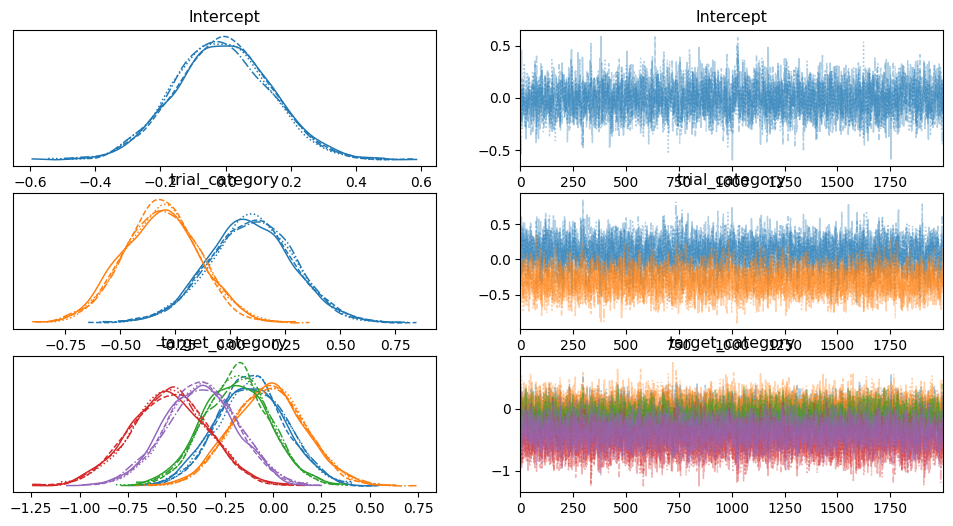

In [11]:
axes = az.plot_trace(simple_idata, var_names=["Intercept", "trial_category", "target_category"])

fig = axes.ravel()[0].figure
fig.show()

##### Model Posterior Visualization

C:\Users\nirjo\AppData\Local\Temp\ipykernel_5320\4177918318.py:4: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



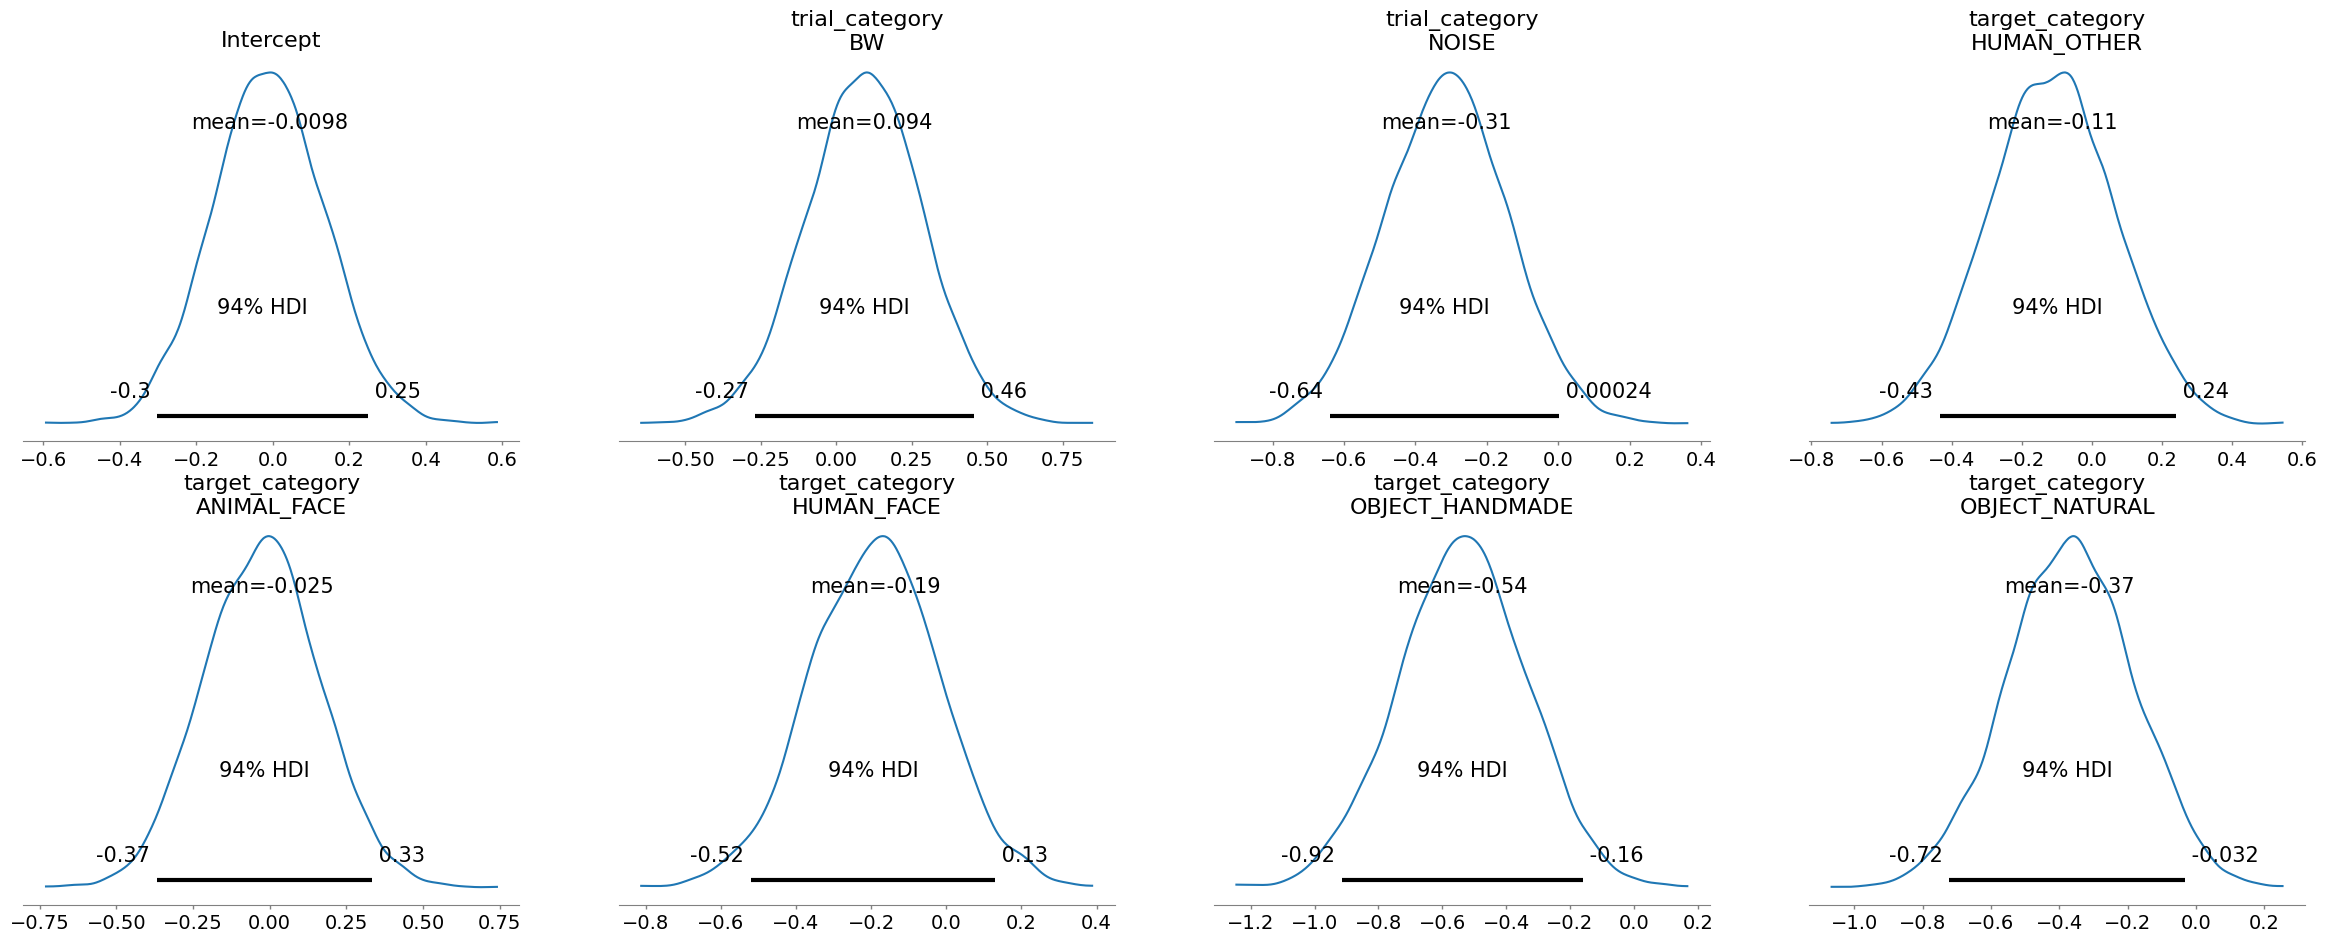

In [12]:
axes = az.plot_posterior(simple_idata, var_names=["Intercept", "trial_category", "target_category"],)

fig = axes.ravel()[0].figure
fig.show()

#### (2) Complex Model
In the more complex model, we include random intercepts **and** random slopes for each subject. This will result in a better fit for subject data, by may take much longer to run. We **do not** include interaction-slopes as random (per-subject) effects, as this will result in very small sample-sizes per sub-group, and may run indefinitely.<br>
Our model formula is:
$$ logit(final) \sim C(trial\_category) * C(target\_category) + (1 + C(trial\_category) + C(target\_category) | subject) $$

In [13]:
start = time.time()

complex_formula = "final ~ trial_category * target_category + (1 + trial_category + target_category | subject)"
complex_model = bmb.Model(complex_formula, SUBSET, family="bernoulli")
complex_idata = complex_model.fit(
    draws=2000, tune=1000, chains=4, cores=2, target_accept=0.95, progressbar=True
)
complex_elapsed = time.time() - start
print(f"Model fitting completed in {int(complex_elapsed // 3600)}:{int((complex_elapsed % 3600) // 60)}:{complex_elapsed % 60:.2f} (hh:mm:ss)")

Modeling the probability that final==1
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, trial_category, target_category, trial_category:target_category, 1|subject_sigma, 1|subject_offset, trial_category|subject_sigma, trial_category|subject_offset, target_category|subject_sigma, target_category|subject_offset]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 278 seconds.


Model fitting completed in 0:4:43.03 (hh:mm:ss)


##### Model Results

In [14]:
az.summary(complex_idata, var_names=["Intercept", "trial_category", "target_category"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
Intercept                        -0.007  0.143  -0.287    0.253      0.003   
trial_category[BW]                0.080  0.203  -0.295    0.466      0.005   
trial_category[NOISE]            -0.321  0.172  -0.631    0.014      0.004   
target_category[HUMAN_OTHER]     -0.117  0.188  -0.467    0.241      0.004   
target_category[ANIMAL_FACE]      0.004  0.235  -0.429    0.457      0.004   
target_category[HUMAN_FACE]      -0.169  0.186  -0.515    0.189      0.004   
target_category[OBJECT_HANDMADE] -0.531  0.207  -0.922   -0.146      0.004   
target_category[OBJECT_NATURAL]  -0.381  0.189  -0.740   -0.038      0.003   

                                  mcse_sd  ess_bulk  ess_tail  r_hat  
Intercept                           0.002    2240.0    3920.0    1.0  
trial_category[BW]                  0.002    1951.0    3586.0    1.0  
trial_category[NOISE]               0.002    2058.0    3574.0    1.0  
target_category[HUMAN_OTHER]        0.002    2836.0    4370.0    1.0  
target_category[ANIMAL_FACE]        0.003    3032.0    4447.0    1.0  
target_category[HUMAN_FACE]         0.002    2638.0    4273.0    1.0  
target_category[OBJECT_HANDMADE]    0.002    2807.0    4715.0    1.0  
target_category[OBJECT_NATURAL]     0.002    3083.0    4717.0    1.0

##### Model Diagnostics

C:\Users\nirjo\AppData\Local\Temp\ipykernel_5320\3015624268.py:4: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



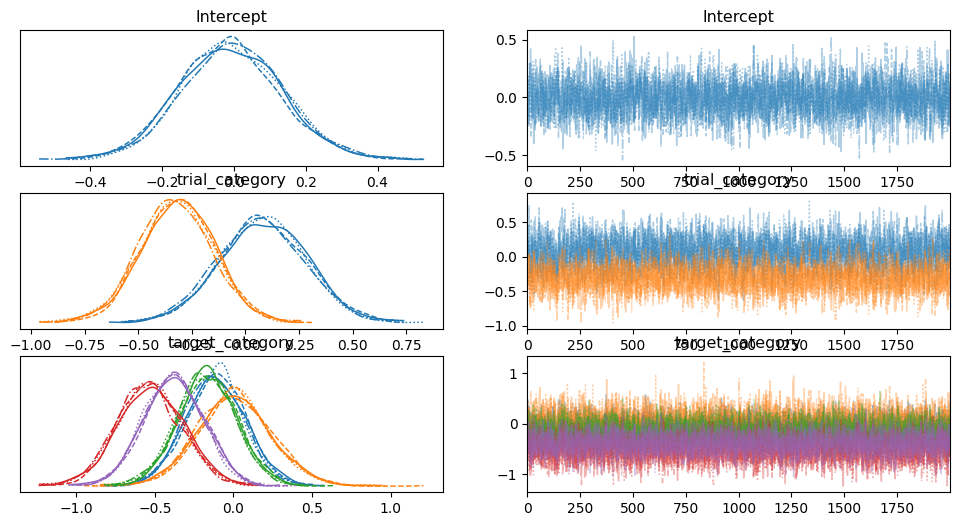

In [15]:
axes = az.plot_trace(complex_idata, var_names=["Intercept", "trial_category", "target_category"])

fig = axes.ravel()[0].figure
fig.show()

##### Model Posterior Visualization

C:\Users\nirjo\AppData\Local\Temp\ipykernel_5320\3490495720.py:4: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



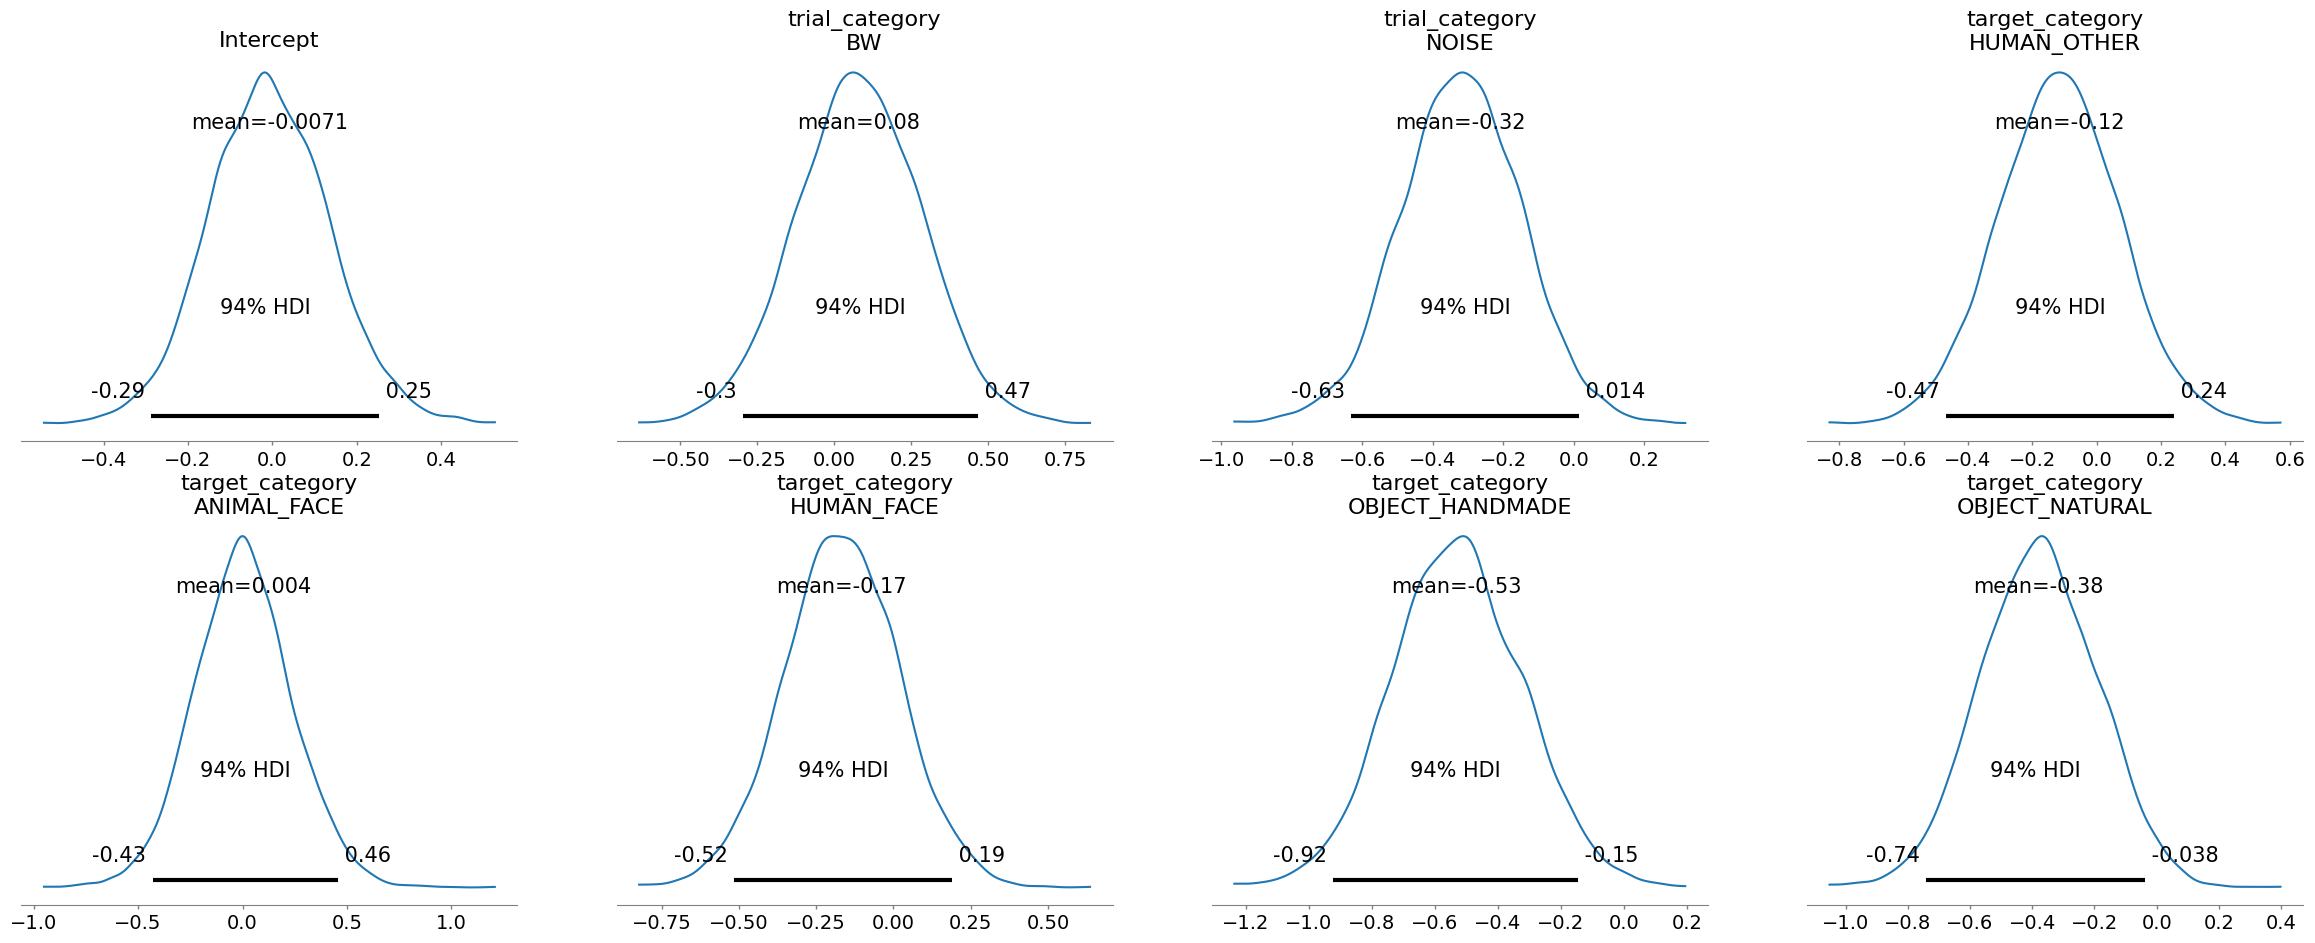

In [16]:
axes = az.plot_posterior(complex_idata, var_names=["Intercept", "trial_category", "target_category"],)

fig = axes.ravel()[0].figure
fig.show()